In [1]:
pip install cached_property

You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from PIL import Image
from cached_property import cached_property
from skimage import io
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torch.utils.data import Dataset
from torchvision import transforms, datasets
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

is_cuda = torch.cuda.is_available()
%matplotlib inline


class FashionDataset(Dataset):
    def __init__(self, csv_file, target_column, root_dir, transform=None, is_train=True, training_size=0.8, is_debug=True):
        self.target_column = target_column
        self.training_size = training_size
        self.csv_file = csv_file
        self.root_dir = root_dir
        self.transform = transform
        self.train = is_train
        self.is_debug = is_debug
        self.train_df, self.test_df = self._get_df()
        
        if self.train: 
            self.train_labels = self.train_df[self.target_column].to_list()
            self.labels_set = set(self.train_labels)
            print(f"# of labels: {len(self.labels_set)}")
        else:
            self.test_labels = self.test_df[self.target_column].to_list()
            self.labels_set = set(self.test_labels)
            print(f"# of labels: {len(self.labels_set)}")
            

    def _get_df(self):
        df = pd.read_csv(os.path.join(self.root_dir, self.csv_file), error_bad_lines=False, warn_bad_lines=False)
        df = df.sample(frac=1, random_state=29, axis="index")
        df = df.dropna(axis=0, subset=[self.target_column])
        
        if self.is_debug:
            df = df.head(10000)
        
        image_ids = []
        for fd in glob.glob(os.path.join(self.root_dir, "images/*.jpg")):
            image_id = os.path.split(fd)[1][:-4]
            image_ids.append(int(image_id))
        # Take a inner set
        common_ids = set(df.id) & set(image_ids)
        
        print("Common ids: ", len(common_ids))
        df = df.loc[df.id.isin(common_ids)]
        
        # Split to training and test
        random_state = np.random.RandomState(29)
        df["is_train"] = random_state.choice([True, False], size=df.shape[0], p=[self.training_size, 1-self.training_size])
        
        train_df = df.loc[(df.is_train==True)]
        self.train_df = self.filter_insufficient_labels(train_df, 5)
        
        # Only keep the labels in the training set.
        train_labels_set = set(self.train_df[self.target_column].to_list())
        test_df = df.loc[(df.is_train==False)]
        test_df = test_df.loc[(test_df[self.target_column].isin(train_labels_set))]
        self.test_df = self.filter_insufficient_labels(test_df, 1)
        
        return self.train_df, self.test_df
    
    
    def filter_insufficient_labels(self, df, thredhold):
        count_df = df.groupby(self.target_column).count().id.reset_index(name="counts")
        df = df.merge(count_df, on=self.target_column, how="left")
        return df.loc[(df.counts > thredhold)].reset_index()


    @cached_property
    def train_data(self):
        print(f"is_training: {self.train}")
        self.image_ids = self.train_df.id.to_list()
        return self._read_images()
    
    @cached_property
    def test_data(self):
        print(f"is_training: {self.train}")
        self.image_ids = self.test_df.id.to_list()
        return self._read_images()
          
        
    def _read_images(self):
        data = []
        for i in self.image_ids:
            filename = os.path.join(self.root_dir, "images", str(i) + ".jpg")
            img = Image.open(filename).convert("L")
            if self.transform:
                img = self.transform(img)
            data.append(img)
        data = torch.stack(data, dim=0)
        return data
    
    def __len__(self):
        if self.train:
            return len(self.train_df)
        else:
            return len(self.test_df)
    
    def __getitem__(self, idx):
        if self.train:
            filename = os.path.join(self.root_dir, "images", str(self.train_df.loc[idx].id) + ".jpg")
            label = self.train_df.loc[idx][self.target_column]
        else:
            filename = os.path.join(self.root_dir, "images", str(self.test_df.loc[idx].id) + ".jpg")
            label = self.test_df.loc[idx][self.target_column]
            
        sample = Image.open(filename).convert("L")

        if self.transform:
            sample = self.transform(sample)
            
        return (sample, label)

In [3]:
class TripletDataset(Dataset):
    """
    Train: For each sample (anchor) randomly chooses a positive and negative samples
    Test: Creates fixed triplets for testing
    """

    def __init__(self, dataset):
        self.dataset = dataset
        self.train = self.dataset.train

        if self.train:
            self.train_labels = self.dataset.train_labels
            self.train_data = self.dataset.train_data
            self.labels_set = set(self.train_labels)
            self.label_to_indices = {label: np.where(np.array(self.train_labels) == label)[0]
                                     for label in self.labels_set}
        else:
            self.test_labels = self.dataset.test_labels
            self.test_data = self.dataset.test_data
            
            self.labels_set = set(self.test_labels)
            self.label_to_indices = {label: np.where(np.array(self.test_labels) == label)[0]
                                     for label in self.labels_set}

            random_state = np.random.RandomState(29)
            
            # Generate fixed triplets for testing len(self.test_data)
            triplets = [[i,
                         random_state.choice(self.label_to_indices[self.test_labels[i]]),
                         random_state.choice(self.label_to_indices[
                                                 np.random.choice(
                                                     list(self.labels_set - set([self.test_labels[i]]))
                                                 )
                                             ])
                         ]
                        for i in range(len(self.test_data))] 
            self.test_triplets = triplets

    def __getitem__(self, index):
        if self.train:
            img1, label1 = self.train_data[index], self.train_labels[index]            
            positive_index = index
#             print(f"Anchor: {index}")
            while positive_index == index:
                positive_index = np.random.choice(self.label_to_indices[label1])
#                 print("Randomly selecting the Postive sample...")
#             print(f"Positive: {positive_index}")
            negative_label = np.random.choice(list(self.labels_set - set([label1])))
            negative_index = np.random.choice(self.label_to_indices[negative_label])
#             print(f"Negative: {negative_index}")
            img2 = self.train_data[positive_index]
            img3 = self.train_data[negative_index]
        else:
            img1 = self.test_data[self.test_triplets[index][0]]
            img2 = self.test_data[self.test_triplets[index][1]]
            img3 = self.test_data[self.test_triplets[index][2]]
        
        # (Anchor, Positive, Negative)
        return (img1, img2, img3), []

    def __len__(self):
        return len(self.dataset)

In [4]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        self.convnet = nn.Sequential(nn.Conv2d(1, 32, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2),
                                     nn.Conv2d(32, 64, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2))

        self.fc = nn.Sequential(nn.Linear(64 * 4 * 4, 256),
                                nn.PReLU(),
                                nn.Linear(256, 256),
                                nn.PReLU(),
                                nn.Linear(256, 2)  # the embedding space is 2
                                )

    def forward(self, x):
        output = self.convnet(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output

    def get_embedding(self, x):
        return self.forward(x)
    
    
    
class TripletNet(nn.Module):
    def __init__(self, embedding_net):
        super(TripletNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2, x3):
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        output3 = self.embedding_net(x3)
        return output1, output2, output3

    def get_embedding(self, x):
        return self.embedding_net(x)

In [5]:
def fit(train_loader, val_loader, model, loss_fn, optimizer, scheduler, n_epochs, is_cuda, log_interval, metrics=[],
        start_epoch=0):
    """
    Trainer
    """
    for epoch in range(0, start_epoch):
        scheduler.step()
        
    print("===> Start training...")
    for epoch in range(start_epoch, n_epochs):
        scheduler.step()

        # Train stage
        train_loss, metrics = train_epoch(train_loader, model, loss_fn, optimizer, is_cuda, log_interval, metrics)
        message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}'.format(epoch + 1, n_epochs, train_loss)
        for metric in metrics:
            message += '\t{}: {}'.format(metric.name(), metric.value())
            
        # Validation stage    
        val_loss, metrics = test_epoch(val_loader, model, loss_fn, is_cuda, metrics)
        val_loss /= len(val_loader)
        message += '\nEpoch: {}/{}. Validation set: Average loss: {:.4f}'.format(epoch + 1, n_epochs, val_loss)
        for metric in metrics:
            message += '\t{}: {}'.format(metric.name(), metric.value())

        print(message)
    print("===> Finish training!")


def train_epoch(train_loader, model, loss_fn, optimizer, is_cuda, log_interval, metrics):
    for metric in metrics:
        metric.reset()

    model.train()
    losses = []
    total_loss = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        target = target if len(target) > 0 else None
        if not type(data) in (tuple, list):
            data = (data,)
        if is_cuda:
            data = tuple(d.cuda() for d in data)
            if target is not None:
                target = target.cuda()

        
        optimizer.zero_grad()
#         data = [len(triplet)=3, batch_size, c, w, h]
        outputs = model(*data)

        if type(outputs) not in (tuple, list):
            outputs = (outputs,)

        loss_inputs = outputs
        if target is not None:
            target = (target,)
            loss_inputs += target

        loss_outputs = loss_fn(*loss_inputs)
        loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
        losses.append(loss.item())
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        for metric in metrics:
            metric(outputs, target, loss_outputs)

        if batch_idx % log_interval == 0:
            message = 'Train: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                batch_idx * len(data[0]), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), np.mean(losses))
            for metric in metrics:
                message += '\t{}: {}'.format(metric.name(), metric.value())

            print(message)
            losses = []

    total_loss /= (batch_idx + 1)
    return total_loss, metrics


def test_epoch(val_loader, model, loss_fn, is_cuda, metrics):
    with torch.no_grad():
        for metric in metrics:
            metric.reset()
        model.eval()
        val_loss = 0
        for batch_idx, (data, target) in enumerate(val_loader):
            target = target if len(target) > 0 else None
            if not type(data) in (tuple, list):
                data = (data,)
            if is_cuda:
                data = tuple(d.cuda() for d in data)
                if target is not None:
                    target = target.cuda()

            outputs = model(*data)

            if type(outputs) not in (tuple, list):
                outputs = (outputs,)
            loss_inputs = outputs
            if target is not None:
                target = (target,)
                loss_inputs += target

            loss_outputs = loss_fn(*loss_inputs)
            loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
            val_loss += loss.item()

            for metric in metrics:
                metric(outputs, target, loss_outputs)

    return val_loss, metrics

In [6]:
# Read raw dataset
mean, std = 0.1307, 0.3081
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
#     transforms.Normalize((mean,), (std,))
])

target_column = "subCategory"
is_debug = True
root_dir="/kaggle/input/fashion-product-images-small/myntradataset"
train_dataset = FashionDataset(is_train=True, target_column=target_column, root_dir=root_dir, csv_file="styles.csv", transform=transform, is_debug=is_debug)
print(train_dataset.train_data.shape)
test_dataset = FashionDataset(is_train=False, target_column=target_column, root_dir=root_dir, csv_file="styles.csv", transform=transform, is_debug=is_debug)
print(test_dataset.test_data.shape)


# Construct triplet dataset
triplet_train_dataset = TripletDataset(train_dataset)
triplet_test_dataset = TripletDataset(test_dataset)


# Construct triplet dataset loader
batch_size = 128
kwargs = {'num_workers': 10, 'pin_memory': True} if is_cuda else {}
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)


# Construct raw dataset loader for embedding and plotting
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)


# Set up the network
# from networks import EmbeddingNet, TripletNet
embedding_net = EmbeddingNet()
model = TripletNet(embedding_net)
if is_cuda:
    model.cuda()

# Set up the loss function
loss_fn = nn.TripletMarginLoss(margin=1.0)

# Set up the optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)


# Set training parameters
n_epochs = 20
log_interval = 50
fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, is_cuda, log_interval)

Common ids:  9999
# of labels: 32
is_training: True
torch.Size([7921, 1, 28, 28])
Common ids:  9999
# of labels: 31
is_training: False
torch.Size([2051, 1, 28, 28])
===> Start training...


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train: [0/7921 (0%)]	Loss: 0.998070
Train: [6400/7921 (81%)]	Loss: 0.533440
Epoch: 1/20. Train set: Average loss: 0.5205
Epoch: 1/20. Validation set: Average loss: 0.3632
Train: [0/7921 (0%)]	Loss: 0.332835
Train: [6400/7921 (81%)]	Loss: 0.336003
Epoch: 2/20. Train set: Average loss: 0.3336
Epoch: 2/20. Validation set: Average loss: 0.3279
Train: [0/7921 (0%)]	Loss: 0.261767
Train: [6400/7921 (81%)]	Loss: 0.289155
Epoch: 3/20. Train set: Average loss: 0.2823
Epoch: 3/20. Validation set: Average loss: 0.2927
Train: [0/7921 (0%)]	Loss: 0.337132
Train: [6400/7921 (81%)]	Loss: 0.238359
Epoch: 4/20. Train set: Average loss: 0.2358
Epoch: 4/20. Validation set: Average loss: 0.2600
Train: [0/7921 (0%)]	Loss: 0.271375
Train: [6400/7921 (81%)]	Loss: 0.205305
Epoch: 5/20. Train set: Average loss: 0.2034
Epoch: 5/20. Validation set: Average loss: 0.2514
Train: [0/7921 (0%)]	Loss: 0.196162
Train: [6400/7921 (81%)]	Loss: 0.187172
Epoch: 6/20. Train set: Average loss: 0.1887
Epoch: 6/20. Validation 

In [7]:
def plot_embeddings(embeddings, labels, classes, xlim=None, ylim=None):
    plt.figure(figsize=(8, 8))
    for i, c in enumerate(classes):
        inds = np.where(labels==c)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[c])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(classes, bbox_to_anchor=(1, 1.))

    
def extract_embeddings(dataloader, dataset, model):
    with torch.no_grad():
        classes = dataset.labels_set
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2)) # the embedding space is 2
        labels = []
        k = 0
        for images, targets in dataloader:
            if is_cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = list(targets)
            k += len(images)
        labels = np.array(labels)
    return embeddings, labels, classes

In [8]:
classes = train_dataset.labels_set


random_state = np.random.RandomState(30)
colors = {}
for c in classes:
    r = lambda: random_state.randint(0, 255)
    color = '#%02X%02X%02X' % (r(),r(),r())
    colors[c] = color

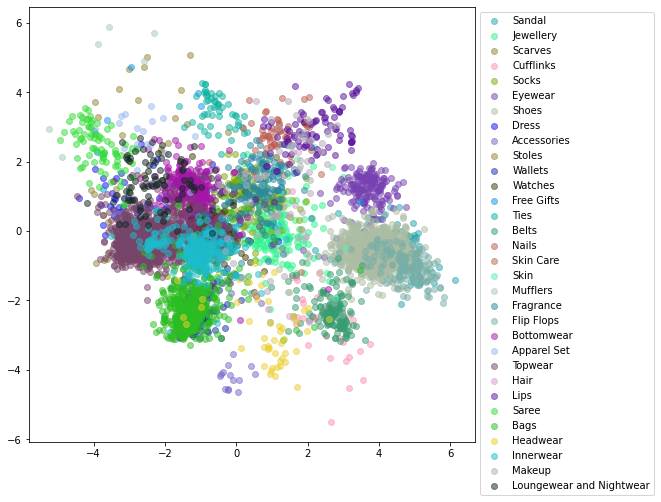

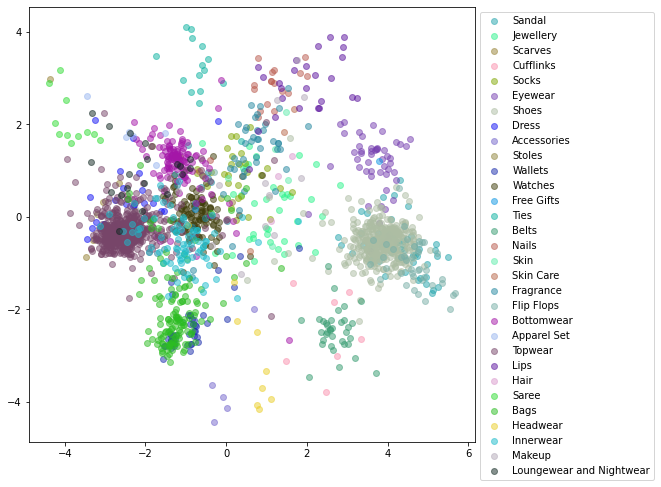

In [9]:
train_embeddings, train_labels, classes = extract_embeddings(train_loader, train_dataset, model)    
plot_embeddings(train_embeddings, train_labels, classes)

val_embeddings, val_labels, classes = extract_embeddings(test_loader, test_dataset, model)
plot_embeddings(val_embeddings, val_labels, classes)

In [10]:
model

TripletNet(
  (embedding_net): EmbeddingNet(
    (convnet): Sequential(
      (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
      (1): PReLU(num_parameters=1)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
      (4): PReLU(num_parameters=1)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (fc): Sequential(
      (0): Linear(in_features=1024, out_features=256, bias=True)
      (1): PReLU(num_parameters=1)
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): PReLU(num_parameters=1)
      (4): Linear(in_features=256, out_features=2, bias=True)
    )
  )
)

In [11]:
embedding_net

EmbeddingNet(
  (convnet): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): PReLU(num_parameters=1)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=256, out_features=2, bias=True)
  )
)